In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
import folium
import cv2 as cv
from datetime import datetime, timedelta

In [2]:
weather_dict = {}
for file in os.listdir('./eie_data/cleaned_gfs/'):
    weather_dict[file.split("_")[2].replace("XX.tif", "")[0:8]] = file

In [3]:
def overlay_image_on_puerto_rico(file_name, band_layer):
    band = rio.open(file_name).read(band_layer)
    m = folium.Map([lat,lon], zoom_start=8)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap=lambda x: (1, 0, 0, x),
    ).add_to(m)
    return m
def plot_scaled(file_name):
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.imshow(file_name, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

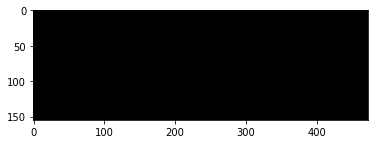

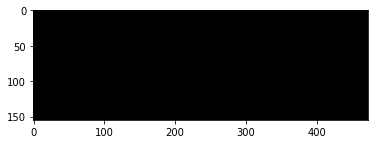

In [16]:
import os
import numpy as np
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et

dst_crs = 'EPSG:3857'

target_projection = "./eie_data/cleaned_s5p_no2/cleaned_s5p_no2_20190623T161923_20190629T180700.tif"
#population = "./eie_data/population/ee_demographic_data.tif"
plot_scaled(rio.open(population).read(1))
with rio.open(target_projection) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rio.open(population, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

lat = 18.2; lon=-66.6
plot_scaled(rio.open(population).read(1))
overlay_image_on_puerto_rico(population, 1)

(148, 475)


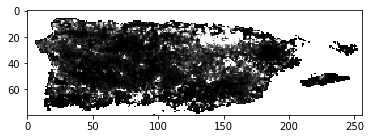

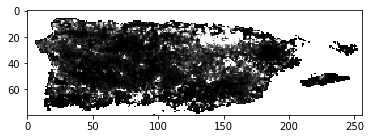

In [5]:
import skimage
from skimage.transform import resize
def overlay_image_on_puerto_rico(band):
    band = band
    m = folium.Map([lat,lon], zoom_start=8)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.5694,-67.32431,],[17.90464,-65.19082]],
        colormap=lambda x: (1, 0, 0, x),
    ).add_to(m)
    return m
lat = 18.2; lon=-66.6
target_projection = rio.open("./eie_data/cleaned_s5p_no2/cleaned_s5p_no2_20190623T161923_20190629T180700.tif").read(1)
projection_shape = target_projection.shape
print(projection_shape)
population = rio.open("./eie_data/population/ee_demographic_data.tif").read(1)
plot_scaled(population)
population_resized = resize(population, projection_shape)
plot_scaled(population)
where_are_NaNs = np.isnan(population)
population[where_are_NaNs] = 0
where_are_NaNs = np.isnan(population_resized)
population_resized[where_are_NaNs] = 0
overlay_image_on_puerto_rico(population)

In [ ]:
import skimage
from skimage.transform import resize
from sklearn.feature_extraction import image

def increment_name(day, month, year):
    day += 1
    if day > 31:
        day = 1
        month += 1
        if month > 12:
            month = 1
            year += 1
    return day, month, year
patch_size = (3,3)
target_projection = rio.open("./eie_data/cleaned_s5p_no2/cleaned_s5p_no2_20190623T161923_20190629T180700.tif").read(1)
projection_shape = target_projection.shape
population = rio.open("./eie_data/population/ee_demographic_data.tif").read(1)
population_resized = resize(population, projection_shape)
where_are_NaNs = np.isnan(population_resized)
population_resized[where_are_NaNs] = 0
population_patches = image.extract_patches_2d(population_resized, patch_size)
population_patches = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in population_patches])

dir_list = os.listdir('./eie_data/cleaned_s5p_no2/')
dir_gfs_list = os.listdir('./eie_data/cleaned_gfs/')
dir_list = sorted(dir_list)
path = './eie_data/cleaned_s5p_no2/'
length = len(dir_list)
first_run = True
im_to_include = 10
for i, file in enumerate(dir_list):
    if i != length-1:
        image_feature = rio.open(path+file)
        shape_feature = image_feature.read(2)
        NO2_patch_feature = image.extract_patches_2d(shape_feature, patch_size)
        NO2_patch_feature = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in NO2_patch_feature])
        week_features = NO2_patch_feature
        image_label = rio.open(path+dir_list[i+1])
        shape_label = image_label.read(2)
        NO2_patch_label = image.extract_patches_2d(shape_label, patch_size)
        NO2_patch_label = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in NO2_patch_label])
        if first_run == True:
            labels = NO2_patch_label
        else:
            labels = np.append(labels, NO2_patch_label, axis=0)
        split_file_name = file.split("_")
        begin_period = split_file_name[3][0:8]
        end_period = split_file_name[4].replace(".tif", "")[0:8]
        day = int(begin_period[-2:])
        month = int(begin_period[-4:-2])
        year = int(begin_period[0:-4])
        date = datetime(year,month,day)
        for j in range(0,7):
            year_str = str(date.year)
            month_str = str(date.month)
            day_str = str(date.day)
            if len(month_str) < 2:
                month_str = "0" + month_str
            if len(day_str) < 2:
                day_str = "0" + day_str
            filename = year_str+month_str+day_str
            date += timedelta(days=1)
            path_gfs = './eie_data/cleaned_gfs/'+weather_dict[filename]
            image_feature = rio.open(path_gfs)
            for q in range (1, 7):
                weather_patch_feature = image.extract_patches_2d(image_feature.read(q), patch_size)
                weather_patch_feature = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in weather_patch_feature])
                week_features = np.concatenate((week_features, weather_patch_feature), axis=1)
        week_features = np.concatenate((week_features, population_patches), axis=1)
        if first_run == True:
            features = week_features
        else:
            features = np.concatenate((features, week_features), axis=0)
    if file == "cleaned_s5p_no2_20190623T161923_20190629T180700.tif":
        break
    first_run = False
    if i > im_to_include-2:
        break
labels = np.array([label[int(patch_size[0]*patch_size[1]/2)] for label in labels])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


In [8]:
pd.DataFrame(features).to_csv("features_w_pop.csv")
pd.DataFrame(labels).to_csv("labels_w_pop.csv")

#Load dataset
#labels = pd.read_csv("labels_w_pop.csv").drop(["Unnamed: 0"], axis=1)
#features = pd.read_csv("features_w_pop.csv").drop(["Unnamed: 0"], axis=1)

#Hyperparameter tuning på alpha - Done
#Fjern =0 vægte og træn model med resterende features uden regul.
#Inkluder population og power plant
#Prøv at standardisere input og output

In [5]:
from sklearn.feature_extraction import image
patch_size = (3,3)
target_projection = rio.open("./eie_data/cleaned_s5p_no2/cleaned_s5p_no2_20190623T161923_20190629T180700.tif").read(1)
projection_shape = target_projection.shape
population = rio.open("./eie_data/population/ee_demographic_data.tif").read(1)
population_resized = resize(population, projection_shape)
where_are_NaNs = np.isnan(population_resized)
population_resized[where_are_NaNs] = 0
population_patches = image.extract_patches_2d(population_resized, patch_size)
population_patches = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in population_patches])
dir_list = os.listdir('./eie_data/cleaned_s5p_no2/')
dir_gfs_list = os.listdir('./eie_data/cleaned_gfs/')
dir_list = sorted(dir_list)
path = './eie_data/cleaned_s5p_no2/'
length = len(dir_list)
first_run = True

for i, file in enumerate(dir_list):
    if i != length-1 and i >10:
        image_feature = rio.open(path+file)
        shape_feature = image_feature.read(2)
        NO2_patch_feature = image.extract_patches_2d(shape_feature, patch_size)
        NO2_patch_feature = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in NO2_patch_feature])
        week_features = NO2_patch_feature
        image_label = rio.open(path+dir_list[i+1])
        shape_label = image_label.read(2)
        NO2_patch_label = image.extract_patches_2d(shape_label, patch_size)
        NO2_patch_label = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in NO2_patch_label])
        if first_run == True:
            labels_test = NO2_patch_label
        else:
            labels_test = np.append(labels_test, NO2_patch_label, axis=0)
        split_file_name = file.split("_")
        begin_period = split_file_name[3][0:8]
        end_period = split_file_name[4].replace(".tif", "")[0:8]
        day = int(begin_period[-2:])
        month = int(begin_period[-4:-2])
        year = int(begin_period[0:-4])
        date = datetime(year,month,day)
        for j in range(0,7):
            year_str = str(date.year)
            month_str = str(date.month)
            day_str = str(date.day)
            if len(month_str) < 2:
                month_str = "0" + month_str
            if len(day_str) < 2:
                day_str = "0" + day_str
            filename = year_str+month_str+day_str
            date += timedelta(days=1)
            path_gfs = './eie_data/cleaned_gfs/'+weather_dict[filename]
            image_feature = rio.open(path_gfs)
            for q in range (1, 7):
                weather_patch_feature = image.extract_patches_2d(image_feature.read(q), patch_size)
                weather_patch_feature = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in weather_patch_feature])
                week_features = np.concatenate((week_features, weather_patch_feature), axis=1)
        week_features = np.concatenate((week_features, population_patches), axis=1)
        if first_run == True:
            features_test = week_features
        else:
            features_test = np.concatenate((features_test, week_features), axis=0)
        first_run = False
    if file == "cleaned_s5p_no2_20190623T161923_20190629T180700.tif":
        break
   
    if i > 10:
        break
labels_test = np.array([label_test[int(patch_size[0]*patch_size[1]/2)] for label_test in labels_test])

In [15]:
#So far 1.7999999999999997e-07 best performing alpha
from sklearn.linear_model import Lasso
for _alpha in np.arange(0.000001, 0.00001, 0.0000001): 
    clf = Lasso(alpha=_alpha)
    clf.fit(features, labels)
    score = clf.score(features_test, labels_test)
    print("For alpha value: " + str(_alpha) + " the score is: " + str(score))

For alpha value: 1e-06 the score is: 0.05687789541896004
For alpha value: 1.1e-06 the score is: 0.053890743233131144
For alpha value: 1.2000000000000002e-06 the score is: 0.05152840657239943
For alpha value: 1.3000000000000003e-06 the score is: 0.04901010431512276
For alpha value: 1.4000000000000004e-06 the score is: 0.04662910602351511
For alpha value: 1.5000000000000005e-06 the score is: 0.04427872824924994
For alpha value: 1.6000000000000006e-06 the score is: 0.041782280603385735
For alpha value: 1.7000000000000007e-06 the score is: 0.039149906153995495
For alpha value: 1.8000000000000008e-06 the score is: 0.037730424210150715
For alpha value: 1.9000000000000009e-06 the score is: 0.036391818358434525
For alpha value: 2.000000000000001e-06 the score is: 0.03494145002095739
For alpha value: 2.100000000000001e-06 the score is: 0.03337931495245683
For alpha value: 2.200000000000001e-06 the score is: 0.03170542193228221
For alpha value: 2.3000000000000013e-06 the score is: 0.029942474236

In [20]:
clf = Lasso(alpha=1.7999999999999997e-07)
clf.fit(features, labels)

Lasso(alpha=1.7999999999999997e-07, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [18]:
from sklearn.feature_extraction import image
patch_size = (3,3)
target_projection = rio.open("./eie_data/cleaned_s5p_no2/cleaned_s5p_no2_20190623T161923_20190629T180700.tif").read(1)
projection_shape = target_projection.shape
population = rio.open("./eie_data/population/ee_demographic_data.tif").read(1)
population_resized = resize(population, projection_shape)
where_are_NaNs = np.isnan(population_resized)
population_resized[where_are_NaNs] = 0
population_patches = image.extract_patches_2d(population_resized, patch_size)
population_patches = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in population_patches])
dir_list = os.listdir('./eie_data/cleaned_s5p_no2/')
dir_gfs_list = os.listdir('./eie_data/cleaned_gfs/')
dir_list = sorted(dir_list)
path = './eie_data/cleaned_s5p_no2/'
length = len(dir_list)
first_run = True

for i, file in enumerate(dir_list):
    if i != length-1 and i >15:
        image_feature = rio.open(path+file)
        shape_feature = image_feature.read(2)
        NO2_patch_feature = image.extract_patches_2d(shape_feature, patch_size)
        NO2_patch_feature = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in NO2_patch_feature])
        week_features = NO2_patch_feature
        image_label = rio.open(path+dir_list[i+1])
        shape_label = image_label.read(2)
        NO2_patch_label = image.extract_patches_2d(shape_label, patch_size)
        NO2_patch_label = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in NO2_patch_label])
        if first_run == True:
            labels_viz = NO2_patch_label
        else:
            labels_viz = np.append(labels_viz, NO2_patch_label, axis=0)
        split_file_name = file.split("_")
        begin_period = split_file_name[3][0:8]
        end_period = split_file_name[4].replace(".tif", "")[0:8]
        day = int(begin_period[-2:])
        month = int(begin_period[-4:-2])
        year = int(begin_period[0:-4])
        date = datetime(year,month,day)
        for j in range(0,7):
            year_str = str(date.year)
            month_str = str(date.month)
            day_str = str(date.day)
            if len(month_str) < 2:
                month_str = "0" + month_str
            if len(day_str) < 2:
                day_str = "0" + day_str
            filename = year_str+month_str+day_str
            date += timedelta(days=1)
            path_gfs = './eie_data/cleaned_gfs/'+weather_dict[filename]
            image_feature = rio.open(path_gfs)
            for q in range (1, 7):
                weather_patch_feature = image.extract_patches_2d(image_feature.read(q), patch_size)
                weather_patch_feature = np.array([i.reshape(patch_size[0]*patch_size[1]) for i in weather_patch_feature])
                week_features = np.concatenate((week_features, weather_patch_feature), axis=1)
        week_features = np.concatenate((week_features, population_patches), axis=1)
        if first_run == True:
            features_viz = week_features
        else:
            features_viz = np.concatenate((features_viz, week_features), axis=0)
        first_run = False
    if file == "cleaned_s5p_no2_20190623T161923_20190629T180700.tif":
        break
   
    if i > 15:
        break
labels_viz = np.array([label_test[int(patch_size[0]*patch_size[1]/2)] for label_test in labels_viz])

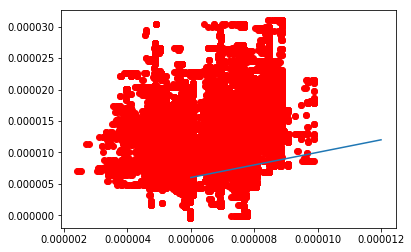

In [21]:
predictions = clf.predict(features_viz)
plt.plot(predictions,labels_viz, 'o', color='red')
plt.plot([0.000006, 0.000012], [0.000006, 0.000012])
plt.show()

In [62]:
output_total_shape = (148,475)
NO2_predictions_full = np.zeros((148,475))
num_patches = (output_total_shape[0]-patch_size[0]+1)*(output_total_shape[1]-patch_size[1]+1)
prediction_shape = (output_total_shape[0]-patch_size[0]+1, output_total_shape[1]-patch_size[1]+1)
print(prediction_shape)
predictions= np.array(predictions).reshape((prediction_shape[0],prediction_shape[1]))
NO2_predictions_full[patch_size[0]-2:output_total_shape[0]-patch_size[0]+2,patch_size[1]-2:output_total_shape[1]-patch_size[1]+2] = predictions
print(NO2_predictions_full)


(146, 473)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.89570068e-06 8.89570068e-06 ... 8.50731395e-06
  8.50731395e-06 0.00000000e+00]
 [0.00000000e+00 8.89570068e-06 8.89570068e-06 ... 8.50731395e-06
  8.50731395e-06 0.00000000e+00]
 ...
 [0.00000000e+00 1.10529158e-05 1.10529158e-05 ... 8.95692394e-06
  8.95692394e-06 0.00000000e+00]
 [0.00000000e+00 1.10529158e-05 1.10529158e-05 ... 8.95692394e-06
  8.95692394e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [63]:
def overlay_image_on_puerto_rico(band):
    band = band
    m = folium.Map([lat,lon], zoom_start=8)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap=lambda x: (1, 0, 0, x),
        origin="lower"
    ).add_to(m)
    return m
lat = 18.2; lon=-66.6
overlay_image_on_puerto_rico(NO2_predictions_full)
#labels = labels.reshape(output_total_shape)


In [19]:
#Patch Extraction Experiment
#(m-a)+1 x (n-b+1) max patches (mxn picture, axb patches)
array = np.array([[0, 1, 2,3],
         [4,5,6,7],
         [8,9,10,11]])
print(array)
array_patches = image.extract_patches_2d(array, (3,3))
print(array_patches)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[[ 0  1  2]
  [ 4  5  6]
  [ 8  9 10]]

 [[ 1  2  3]
  [ 5  6  7]
  [ 9 10 11]]]


2

In [17]:
# Best value = 7.3e-07
NO2_predictions_full_correct = np.zeros((148,475))
NO2_predictions_full_correct[patch_size[0]-2:output_total_shape[0]-patch_size[0]+2,patch_size[1]-2:output_total_shape[1]-patch_size[1]+2] = np.array(labels).reshape((prediction_shape[0],prediction_shape[1]))
print(NO2_predictions_full_correct)
overlay_image_on_puerto_rico(NO2_predictions_full_correct)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.35998134e-05 1.35998134e-05 ... 1.01855303e-05
  8.91707714e-06 0.00000000e+00]
 [0.00000000e+00 1.35998134e-05 1.35998134e-05 ... 6.87176453e-06
  7.77640798e-06 0.00000000e+00]
 ...
 [0.00000000e+00 1.27429348e-05 1.27429348e-05 ... 2.58759042e-06
  2.58759042e-06 0.00000000e+00]
 [0.00000000e+00 1.27429348e-05 1.27429348e-05 ... 2.58759042e-06
  2.58759042e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [6]:
features_w_pop = pd.read_csv("features_w_pop.csv").drop(["Unnamed: 0"], axis=1)
print(features_w_pop.shape)
features = pd.read_csv("features_images.csv").drop(["Unnamed: 0"], axis=1)
print(features.shape)

(690580, 396)
(138116, 387)


In [10]:
print(labels.shape)

(69058, 9)
